## Introduction
The prevalence of online learning has surged, offering a convenient avenue for acquiring new skills and knowledge in the age of the internet. Nonetheless, the autonomy required in online learning presents challenges for students who must independently motivate and regulate their learning processes. A key inquiry arises: How can we identify and provide support to students at risk of dropping out or failing in online courses? This question steers the focus of our data science project.

The primary objective of this initiative is to construct a predictive model capable of categorizing students' performance in online courses based on their interactions within the learning environment. Leveraging historical data from prior student cohorts engaged in diverse online courses, such as coding fundamentals, data science, and machine learning, the model will undergo validation using the current cohort to assess its accuracy and reliability.

The document's structure unfolds as follows: Section 2 delineates the dataset, encompassing its attributes and sources. Section 3 elucidates the methods and algorithms employed in developing and testing the predictive model. Section 4 delves into presenting the results and analysis, encompassing performance metrics and their interpretation. Section 5 engages with the discussion of limitations and implications, along with potential avenues for future enhancements to the project.

### The dataset
The data utilized in this project originates from the Open University, an online institution based in the UK that provides accredited degrees to distance learners. Anonymized data has been made available by the university, covering seven courses—three in the social sciences and four in STEM fields—during the academic years 2012/2013 and 2013/2014. The courses undergo biannual repetition, referred to as a 'presentation,' though not all presentations of each course are represented in the dataset. For detailed insights into the data's selection and anonymization processes, please refer to the US National Institute of Health site, where the data is curated for scientific inquiry. The dataset encompasses various data types, and subsequent sections will delve into the analysis of correlations among different columns, as well as their distributional characteristics.

In [1]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler, LabelEncoder
from xgboost import XGBClassifier
import seaborn as sns
import matplotlib.pyplot as plt
import warnings

%matplotlib inline
warnings.filterwarnings("ignore")
sns.set_style('whitegrid')

pd.set_option('display.max_columns', None)
sns.set(font_scale=1.5)

In [2]:
# Import data
registrations = pd.read_csv('./data/anonymisedData/studentRegistration.csv')
course_info = pd.read_csv('./data/anonymisedData/courses.csv')
students = pd.read_csv('./data/anonymisedData/studentInfo.csv')
student_vle = pd.read_csv('./data/anonymisedData/studentVle.csv')
vle_info = pd.read_csv('./data/anonymisedData/vle.csv')
student_assessments = pd.read_csv('./data/anonymisedData/studentAssessment.csv', skiprows=[128223, 64073])
assessments_info = pd.read_csv('./data/anonymisedData/assessments.csv')

index_columns = ['code_module', 'code_presentation', 'id_student']

# Merge registrations data
merge_data = pd.merge(students, registrations, on=index_columns, validate='1:1')
merge_data = pd.merge(merge_data, course_info,
                              on=['code_module', 'code_presentation'], validate='many_to_one')
merge_data.dropna(subset=['date_registration', 'imd_band'], inplace=True)

not_withdrawn = merge_data['date_unregistration'].isna()
withdrawn_after_predict = (merge_data['final_result'] == 'Withdrawn') \
                          & (merge_data['date_unregistration'] > 0)

merge_data = merge_data[not_withdrawn | withdrawn_after_predict]
merge_data['date_unregistration'].fillna(merge_data['module_presentation_length'], inplace=True)
merge_data = merge_data[merge_data['date_unregistration']
                                        <= merge_data['module_presentation_length']]

# Merge VLE data
vle = pd.merge(student_vle, vle_info,
               how='left', on=['id_site', 'code_module', 'code_presentation'], validate='m:1').drop(columns=['week_from', 'week_to'])

total_activities = vle.groupby(by=index_columns).count().reset_index().drop(columns=['date', 'sum_click', 'activity_type'])
date_grouped = vle.groupby(by=index_columns + ['date']).count().reset_index()
days_studied = date_grouped.groupby(by=index_columns).count().reset_index().drop(columns=['id_site', 'sum_click', 'activity_type'])
clicks = vle.groupby(by=index_columns).sum().reset_index().drop(columns=['id_site', 'date'])

merge_data = pd.merge(merge_data, days_studied, on=index_columns, how='left')
merge_data = pd.merge(merge_data, total_activities, on=index_columns, how='left')
merge_data = pd.merge(merge_data, clicks, on=index_columns, how='left')

# Merge Assessments data
assessments = pd.merge(student_assessments, assessments_info, how='left', on='id_assessment')
assessments.dropna(subset=['score'], inplace=True)
assessments.drop(columns=['is_banked', 'weight'], inplace=True)

num_assessments = assessments.groupby(by=index_columns).count().reset_index()
total_assessments = assessments_info.groupby(by=['code_module', 'code_presentation']).count().reset_index().drop(columns=['assessment_type', 'date', 'weight'])
total_assessments = total_assessments.rename(columns={'id_assessment': 'total_assessments'})
num_assessments = pd.merge(num_assessments, total_assessments,
                           how='left', on=['code_module', 'code_presentation'])
num_assessments['id_assessment'] = num_assessments['id_assessment'] / num_assessments['total_assessments']
num_assessments.drop(columns=['total_assessments', 'date_submitted', 'score', 'date', 'assessment_type'], inplace=True)

avg_score = assessments.groupby(by=index_columns).mean().reset_index().drop(columns=['date_submitted', 'id_assessment', 'date'])

merge_data = pd.merge(merge_data, num_assessments, on=index_columns, how='left')
merge_data = pd.merge(merge_data, avg_score, on=index_columns, how='left')
merge_data = merge_data.fillna(value=0)

# Rename columns
new_cols = {'id_assessment': 'assessments_completed',
            'score': 'average_assessment_score', 'date': 'days_studied',
            'id_site': 'activities_engaged', 'sum_click': 'total_clicks'}
merge_data = merge_data.rename(columns=new_cols)
merge_data = merge_data[(merge_data['total_clicks'] < 4035) & (merge_data['activities_engaged'] < 1135)]
merge_data.head()

,code_module,code_presentation,id_student,gender,region,highest_education,imd_band,age_band,num_of_prev_attempts,studied_credits,disability,final_result,date_registration,date_unregistration,module_presentation_length,days_studied,activities_engaged,total_clicks,assessments_completed,average_assessment_score
0,AAA,2013J,11391,M,East Anglian Region,HE Qualification,90-100%,55<=,0,240,N,Pass,-159.0,268.0,268,40.0,196.0,934.0,0.833333,82.0
1,AAA,2013J,28400,F,Scotland,HE Qualification,20-30%,35-55,0,60,N,Pass,-53.0,268.0,268,80.0,430.0,1435.0,0.833333,66.4
2,AAA,2013J,30268,F,North Western Region,A Level or Equivalent,30-40%,35-55,0,60,Y,Withdrawn,-92.0,12.0,268,12.0,76.0,281.0,0.000000,0.0
3,AAA,2013J,31604,F,South East Region,A Level or Equivalent,50-60%,35-55,0,60,N,Pass,-52.0,268.0,268,123.0,663.0,2158.0,0.833333,76.0
4,AAA,2013J,32885,F,West Midlands Region,Lower Than A Level,50-60%,0-35,0,60,N,Pass,-176.0,268.0,268,70.0,352.0,1034.0,0.833333,54.4


The final result is the label that marks whether the student will withdrawn/fail or succeed in the study.

In [14]:
value_counts = merge_data['final_result'].value_counts()
value_counts

Pass           10464
Withdrawn       6849
Fail            6789
Distinction     2165
Name: final_result, dtype: int64

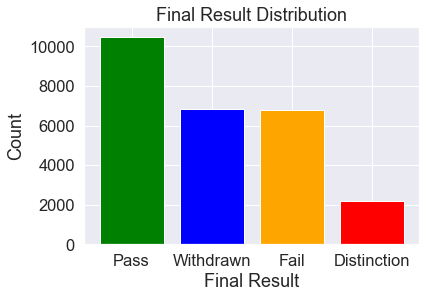

In [15]:
# Plotting the bar chart
plt.bar(value_counts.index, value_counts.values, color=['green', 'blue', 'orange', 'red'])
plt.title('Final Result Distribution')
plt.xlabel('Final Result')
plt.ylabel('Count')
plt.show()

In [4]:
merge_data.describe()

,id_student,num_of_prev_attempts,studied_credits,date_registration,date_unregistration,module_presentation_length,days_studied,activities_engaged,total_clicks,assessments_completed,average_assessment_score
count,2.626700e+04,26267.000000,26267.000000,26267.000000,26267.000000,26267.000000,26267.000000,26267.000000,26267.000000,26267.000000,26267.000000
mean,7.024447e+05,0.167016,77.545209,-66.621769,212.252598,256.008490,50.916131,275.208855,936.908593,0.566581,61.732220
std,5.460287e+05,0.483659,39.294594,47.718282,82.476836,13.099283,43.109523,246.232380,938.657332,0.364268,29.149705
min,6.516000e+03,0.000000,30.000000,-311.000000,1.000000,234.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,5.058400e+05,0.000000,60.000000,-95.000000,223.000000,241.000000,15.000000,77.000000,210.000000,0.166667,54.000000
50%,5.895550e+05,0.000000,60.000000,-53.000000,241.000000,262.000000,40.000000,205.000000,613.000000,0.750000,71.571429
75%,6.433875e+05,0.000000,90.000000,-29.000000,268.000000,268.000000,77.000000,413.000000,1383.500000,0.900000,82.166667
max,2.698591e+06,6.000000,430.000000,167.000000,269.000000,269.000000,276.000000,1134.000000,4032.000000,1.000000,100.000000


#### Preprocess

In [3]:
merge_data.columns

Index(['code_module', 'code_presentation', 'id_student', 'gender', 'region',
       'highest_education', 'imd_band', 'age_band', 'num_of_prev_attempts',
       'studied_credits', 'disability', 'final_result', 'date_registration',
       'date_unregistration', 'module_presentation_length', 'days_studied',
       'activities_engaged', 'total_clicks', 'assessments_completed',
       'average_assessment_score'],
      dtype='object')

In [11]:
target = merge_data["final_result"]
target =pd.get_dummies(target)

data = merge_data.drop(columns = "final_result", axis = 1)
data = data.loc[:, (merge_data != 0).any(axis=0)]

In [12]:
target.head()

,Distinction,Fail,Pass,Withdrawn
0,0,0,1,0
1,0,0,1,0
2,0,0,0,1
3,0,0,1,0
4,0,0,1,0


In [19]:
cor_of_Pass = data.corrwith(other = target["Pass"], method = 'pearson')
cor_of_Withdrawn = data.corrwith(other = target["Withdrawn"],method = 'pearson')
cor_of_Fail= data.corrwith(other = target["Fail"],method = 'pearson')
cor_of_Distinction = data.corrwith(other = target["Distinction"],method = 'pearson')

In [26]:
def plot_Tail3_correlations(top_correlations, column):
    plt.figure(figsize=(10, 5))
    # Plotting the bar chart
    plt.bar(top_correlations.index, top_correlations.values, color='skyblue')
    plt.title(f'Tail 3 Correlations with "{column}"')
    plt.xlabel('Features')
    plt.ylabel('Absolute Correlation')
    plt.show()

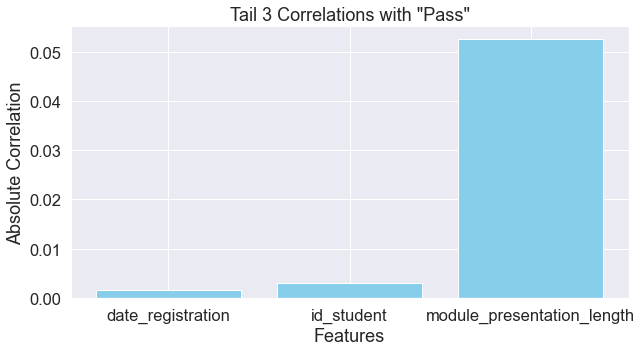

In [27]:
# Take the absolute values and get the tail 3
plot_Tail3_correlations(cor_of_Pass.abs().nsmallest(3), "Pass")

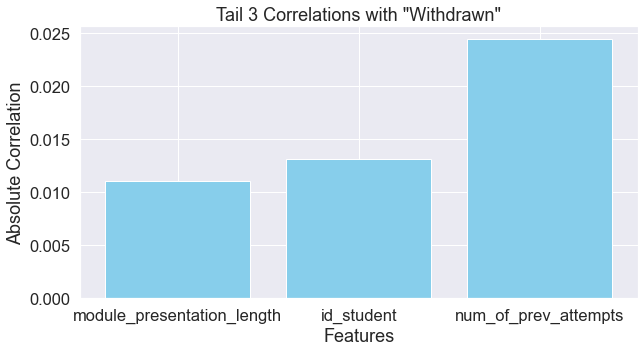

In [28]:
plot_Tail3_correlations(cor_of_Withdrawn.abs().nsmallest(3), "Withdrawn")

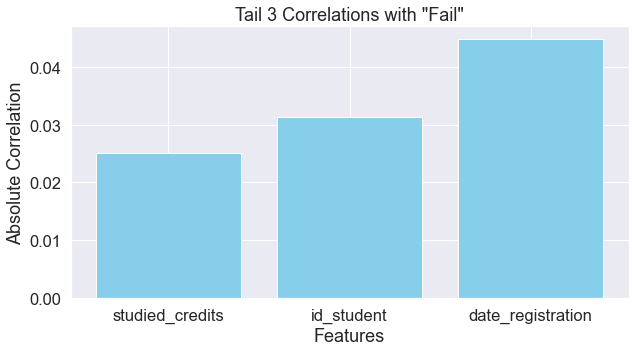

In [29]:
plot_Tail3_correlations(cor_of_Fail.abs().nsmallest(3), "Fail")

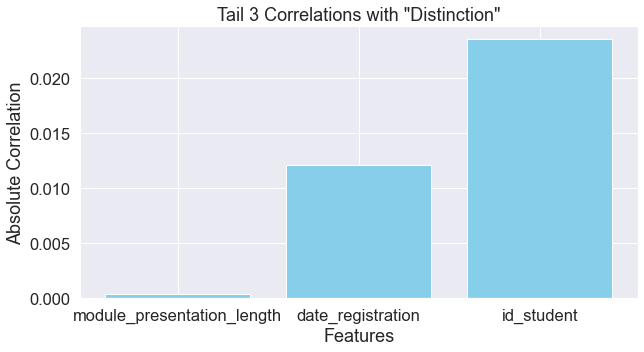

In [30]:
plot_Tail3_correlations(cor_of_Distinction.abs().nsmallest(3), "Distinction")

### Column Correlations
From the correlation graph, it can be seen that there are some columns that are clearly not relevant to the results, and for this reason these irrelevant columns need to be removed.

In [33]:
merge_data.drop(columns = ['id_student', 'imd_band','gender','age_band','disability','studied_credits',
                   'module_presentation_length','date_registration', 'num_of_prev_attempts'], inplace = True)

In [37]:
merge_data.head()

,code_module,code_presentation,region,highest_education,final_result,date_unregistration,days_studied,activities_engaged,total_clicks,assessments_completed,average_assessment_score
0,AAA,2013J,East Anglian Region,HE Qualification,Pass,268.0,40.0,196.0,934.0,0.833333,82.0
1,AAA,2013J,Scotland,HE Qualification,Pass,268.0,80.0,430.0,1435.0,0.833333,66.4
2,AAA,2013J,North Western Region,A Level or Equivalent,Withdrawn,12.0,12.0,76.0,281.0,0.000000,0.0
3,AAA,2013J,South East Region,A Level or Equivalent,Pass,268.0,123.0,663.0,2158.0,0.833333,76.0
4,AAA,2013J,West Midlands Region,Lower Than A Level,Pass,268.0,70.0,352.0,1034.0,0.833333,54.4


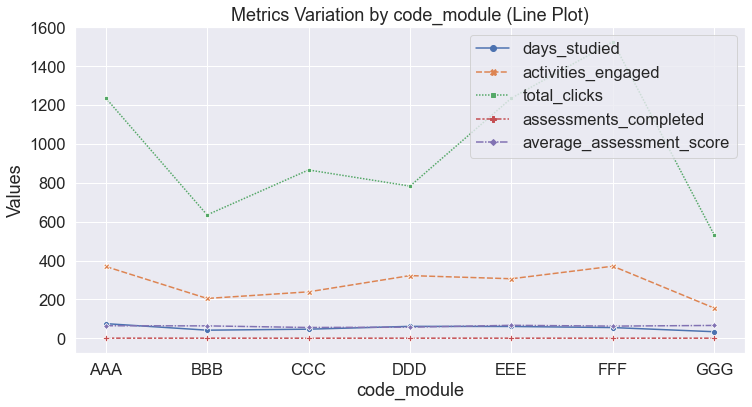

In [41]:
grouped_data = merge_data.groupby('code_module').mean()

# Line plot
plt.figure(figsize=(12, 6))
sns.lineplot(data=grouped_data[['days_studied', 'activities_engaged', 'total_clicks', 'assessments_completed', 'average_assessment_score']], markers=True)
plt.title('Metrics Variation by code_module (Line Plot)')
plt.xlabel('code_module')
plt.ylabel('Values')
plt.legend(loc='upper right')
plt.show()

I've found that the difference in `days_studied` fluctuates greatly from mod to mod, as well as the difference in `activaties_engaged`.

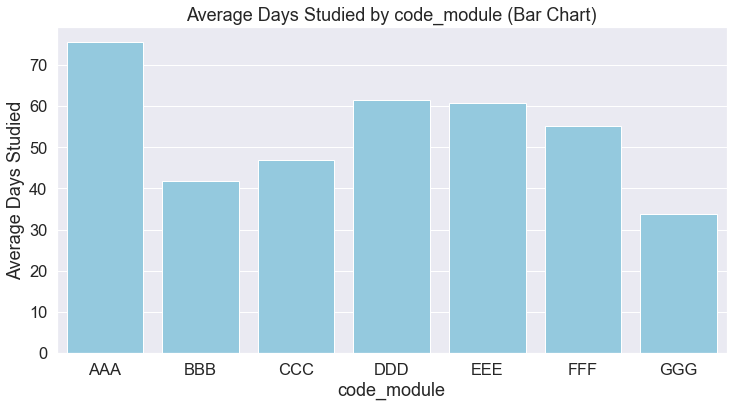

In [42]:
# Bar chart
plt.figure(figsize=(12, 6))
sns.barplot(x=grouped_data.index, y='days_studied', data=grouped_data, color='skyblue')
plt.title('Average Days Studied by code_module (Bar Chart)')
plt.xlabel('code_module')
plt.ylabel('Average Days Studied')
plt.show()

## Data clean
Replace null values with mean values, encode columns that are character types with numeric types.

In [46]:
from sklearn.preprocessing import LabelEncoder

# Handling missing values
preprocessed_data = merge_data.fillna(merge_data.mean())
preprocessed_data = preprocessed_data.drop('final_result', axis=1)

# Encoding categorical variables
label_encoder = LabelEncoder()
# Apply label encoding to each categorical column
categorical_columns = ['code_module', 'code_presentation', 'region', 'highest_education']
for column in categorical_columns:
    preprocessed_data[column] = label_encoder.fit_transform(preprocessed_data[column])

In [47]:
preprocessed_data.head()

,code_module,code_presentation,region,highest_education,date_unregistration,days_studied,activities_engaged,total_clicks,assessments_completed,average_assessment_score
0,0,1,0,1,268.0,40.0,196.0,934.0,0.833333,82.0
1,0,1,6,1,268.0,80.0,430.0,1435.0,0.833333,66.4
2,0,1,5,0,12.0,12.0,76.0,281.0,0.000000,0.0
3,0,1,7,0,268.0,123.0,663.0,2158.0,0.833333,76.0
4,0,1,11,2,268.0,70.0,352.0,1034.0,0.833333,54.4


### Scaling
To normalize the numerical features in your preprocessed_data, we can use techniques such as Min-Max scaling or Standardization (Z-score normalization).

In [49]:
# Creating a StandardScaler
scaler = StandardScaler()

# Applying Standardization to selected columns
preprocessed_data = scaler.fit_transform(preprocessed_data)
preprocessed_data[:5]

array([[-1.73434201e+00, -7.43350864e-01, -1.60485814e+00,
        -2.00147588e-03,  6.75928731e-01, -2.53223360e-01,
        -3.21689466e-01, -3.09873241e-03,  7.32309581e-01,
         6.95312875e-01],
       [-1.73434201e+00, -7.43350864e-01,  6.37943840e-03,
        -2.00147588e-03,  6.75928731e-01,  6.74663532e-01,
         6.28650428e-01,  5.30652531e-01,  7.32309581e-01,
         1.60134326e-01],
       [-1.73434201e+00, -7.43350864e-01, -2.62160158e-01,
        -1.03284004e+00, -2.42803217e+00, -9.02744185e-01,
        -8.09043258e-01, -6.98786507e-01, -1.55542491e+00,
        -2.11780514e+00],
       [-1.73434201e+00, -7.43350864e-01,  2.74919035e-01,
        -1.03284004e+00,  6.75928731e-01,  1.67214194e+00,
         1.57492904e+00,  1.30091633e+00,  7.32309581e-01,
         4.89474971e-01],
       [-1.73434201e+00, -7.43350864e-01,  1.34907742e+00,
         1.02883709e+00,  6.75928731e-01,  4.42691809e-01,
         3.11870463e-01,  1.03438446e-01,  7.32309581e-01,
        -2.

## Modeling

In [59]:
X=preprocessed_data
merge_data["final_result"] = label_encoder.fit_transform(merge_data["final_result"])
Y=merge_data["final_result"].values

In [60]:
from sklearn.model_selection import train_test_split

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=0)

#split X_train and Y_train into training set and a validation set
X_train, X_val, Y_train, Y_val = train_test_split(X_train, Y_train, test_size=0.1, random_state=0)
print('train:', X_train.shape, Y_train.shape)
print('validation:', X_val.shape, Y_val.shape)
print('test:', X_test.shape, Y_test.shape)

train: (18911, 10) (18911,)
validation: (2102, 10) (2102,)
test: (5254, 10) (5254,)


### Weighted Classification Accuracy

In [61]:
def weighted_accuracy(confusion):
    # return the weighted classification accuracy
    M=confusion.copy().astype('float32')
    for k in range(0, M.shape[0]):
        M[k]/=M[k].sum()+1e-8
    acc = M.diagonal().sum()/M.sum()
    return acc

### Logistic regression
Logistic regression is a statistical learning method widely used to solve binary classification problems. Despite the name "regression", it is actually a classification algorithm. Logistic regression is based on a linear model and achieves classification by mapping the output of a linear combination to a probability range using a sigmoid function. A linear combination of input features for logistic regression is represented as follows:
$$z = {b_0} + {b_1} \cdot {x_1} + {b_2} \cdot {x_2} +  \ldots  + {b_n} \cdot {x_n}$$ and the loss function is:
$$\mathcal{L} =  - \frac{1}{m}\sum\limits_{i = 1}^m {\left[ {{y_i} \cdot \log (P(Y = 1|{X_i})) + (1 - {y_i}) \cdot \log (1 - P(Y = 1|{X_i}))} \right]} $$
The goal of logistic regression is to learn the weights by minimizing the loss function so that the probabilistic predictions of the model are as close as possible to the actual labels.

In [62]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix

#set class_weight='balanced'
LR=LogisticRegression(penalty='none', class_weight='balanced', solver='newton-cg', random_state=0)
LR.fit(X_train, Y_train)
Y_val_pred=LR.predict(X_val)
confusion_val=confusion_matrix(Y_val, Y_val_pred)
acc_val=weighted_accuracy(confusion_val)
Y_test_pred=LR.predict(X_test)
confusion_test=confusion_matrix(Y_test, Y_test_pred)
acc_test=weighted_accuracy(confusion_test)
print('classification accuracy on validation set is ', acc_val)
print('classification accuracy on test set is ', acc_test)

classification accuracy on validation set is  0.81577927
classification accuracy on test set is  0.8091955


### Random Forest
Random Forest is an integrated learning method that improves overall performance by combining multiple decision trees. It combines the simplicity of decision trees with the power of integrated learning. Random forests can be applied to classification and regression problems and excel in handling high dimensional data, large amounts of data and feature selection. In Random Forest, each decision tree is constructed by random sampling of training data and random selection of features. In this way, each decision tree is independent and they provide strong generalization capabilities for random samples and random features.Decision trees are constructed in the following steps: for each decision tree construction, a new subset is constructed by bootstrap sampling, i.e., randomly taking samples from the training set with putback. At each node, a certain number of features are randomly selected from all features to ensure that each decision tree does not use all features.

Decision trees are constructed using the selected features and samples. After constructing the decision trees voting or averaging is required, for classification problems each decision tree votes to give a category. The final prediction is the category that gets the most votes. For regression problems, each decision tree gives a predicted value. The final prediction is the average of these predicted values.

In [63]:
max_depth_list = np.arange(1, 20)

acc_train_list=[]
acc_val_list=[]
for deep in max_depth_list:
    model = RandomForestClassifier(class_weight='balanced', n_estimators=20, max_depth=deep, random_state=0)
    model.fit(X_train, Y_train)

    Y_val_pred=model.predict(X_val)
    confusion_val=confusion_matrix(Y_val, Y_val_pred)
    acc_val=weighted_accuracy(confusion_val)
    Y_train_pred=model.predict(X_train)
    confusion_train=confusion_matrix(Y_train, Y_train_pred)
    acc_train=weighted_accuracy(confusion_train)

    acc_train_list.append(acc_train)
    acc_val_list.append(acc_val)

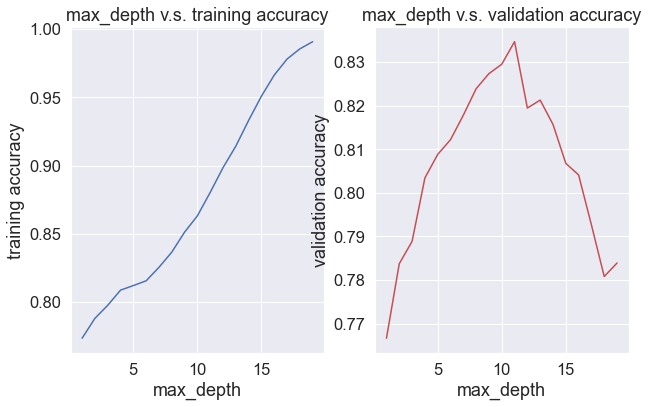

In [64]:
fig, ax = plt.subplots(1,2, figsize=(10,6))
ax[0].plot(max_depth_list, acc_train_list, 'b')
ax[0].set_xlabel('max_depth')
ax[0].set_ylabel('training accuracy')
ax[0].set_title('max_depth v.s. training accuracy')
ax[0].grid(True)
ax[1].plot(max_depth_list, acc_val_list, 'r')
ax[1].set_xlabel('max_depth')
ax[1].set_ylabel('validation accuracy')
ax[1].set_title('max_depth v.s. validation accuracy')
ax[1].grid(True)

From the above figure, we see that training accuracy keeps increasing as max_depth increases. <br>
Validation accuracy reveals the ability of the model predicting y on new data samples that the model did not see during training. <br>
This is why we use validation accuracy curve to find the best hyper-parameter

### XGBClassifier
XGBoost is a gradient boosting algorithm that is widely used in classification and regression problems. It is an integrated learning method based on decision trees, which improves the overall model performance by iteratively training a series of weak learners (decision trees), where each round tries to correct the errors of the previous rounds.XGBoost performs well in handling structured data, feature engineering, and dealing with missing values.The objective function of XGBoost consists of two parts, namely, a loss function and a regularization term:
$$\mathcal{L}_\theta  = \sum\limits_{i = 1}^n L ({y_i},{\hat y_i}) + \sum\limits_{k = 1}^K \Omega  ({f_k})$$
By optimizing the objective function, XGBoost iteratively builds weak learners, correcting the errors of previous rounds in each round, resulting in a robust integrated model. XGBoost has advantages through parallel computation, feature importance evaluation, and so on.

In [66]:
xgb_model = XGBClassifier()
xgb_model.fit(X_train, Y_train)
Y_val_pred=model.predict(X_val)
confusion_val=confusion_matrix(Y_val, Y_val_pred)
acc_val=weighted_accuracy(confusion_val)
print("The accuracy of XGBClassifier:", acc_val)

The accuracy of XGBClassifier: 0.7839098
